# Nama: Hendrikus Yohanes Wunga
# NIM: 225314039

## Penjelasan Kode

Kode ini memuat beberapa library penting yang digunakan dalam analisis data, visualisasi, dan pembelajaran mesin:

1. **Import Library**:
    ```python
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import tensorflow as tf
    import warnings
    ```

    - `matplotlib.pyplot`: Digunakan untuk membuat plot dan visualisasi data.
    - `numpy`: Digunakan untuk operasi numerik, seperti array dan fungsi matematika.
    - `os`: Digunakan untuk berinteraksi dengan sistem operasi, seperti mengelola file dan direktori.
    - `tensorflow`: Digunakan untuk membuat dan melatih model pembelajaran mesin dan jaringan saraf.
    - `warnings`: Digunakan untuk mengelola peringatan (warnings) dalam kode Python.

2. **Mengabaikan Peringatan**:
    ```python
    warnings.filterwarnings("ignore")
    ```

    - Kode ini digunakan untuk mengabaikan semua peringatan yang mungkin muncul selama eksekusi kode, sehingga output lebih bersih dan hanya menampilkan informasi yang penting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

## Preprocessing Data

Mengunduh Data
kita akan menggunakan dataset yang berisi beberapa ribu gambar kucing dan anjing. Unduh dan ekstrak file zip yang berisi gambar-gambar tersebut, lalu buatlah tf.data.Dataset untuk pelatihan dan validasi dengan menggunakan utilitas tf.keras.utils.image_dataset_from_directory


In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Menampilkan sembilan gambar dan label pertama dari set pelatihan

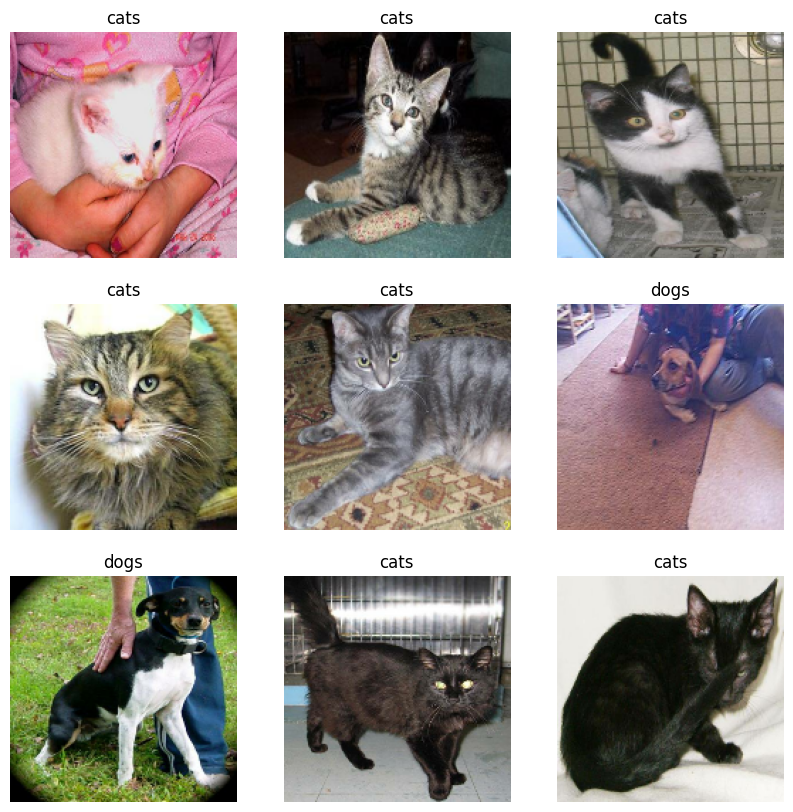

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Untuk membuat set uji, kita pertama-tama menentukan berapa banyak batch data yang tersedia di set validasi menggunakan `tf.data.experimental.cardinality(validation_dataset)`. Lalu, kita ambil 20% dari set validasi untuk digunakan sebagai set uji menggunakan `validation_dataset.take(val_batches // 5)`, dan sisanya dipertahankan untuk set validasi dengan menggunakan `validation_dataset.skip(val_batches // 5)`.

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Setelah itu, kita mencetak jumlah batch di set validasi dan set uji

In [5]:
print('Jumlah batch validasi: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Jumlah batch pengujian: %d' % tf.data.experimental.cardinality(test_dataset))

Jumlah batch validasi: 26
Jumlah batch pengujian: 6


# Mengonfigurasi dataset untuk kinerja
Kode ini bertujuan untuk meningkatkan kinerja pelatihan model dengan menggunakan prefetching. Prefetching adalah teknik yang memungkinkan pengambilan data untuk dilakukan secara asinkron, sehingga sementara CPU atau GPU sedang melakukan komputasi, data dapat dipersiapkan secara paralel untuk batch berikutnya.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Menggunakan Augmentasi Data
`data_augmentation` adalah sebuah sequential model dalam TensorFlow Keras yang digunakan untuk melakukan augmentasi data pada gambar. Augmentasi data adalah teknik yang digunakan dalam pelatihan model machine learning untuk meningkatkan keragaman data dan mengurangi overfitting dan bertujuan untuk meningkatkan performa model pembelajaran mesin dalam mengklasifikasikan gambar.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

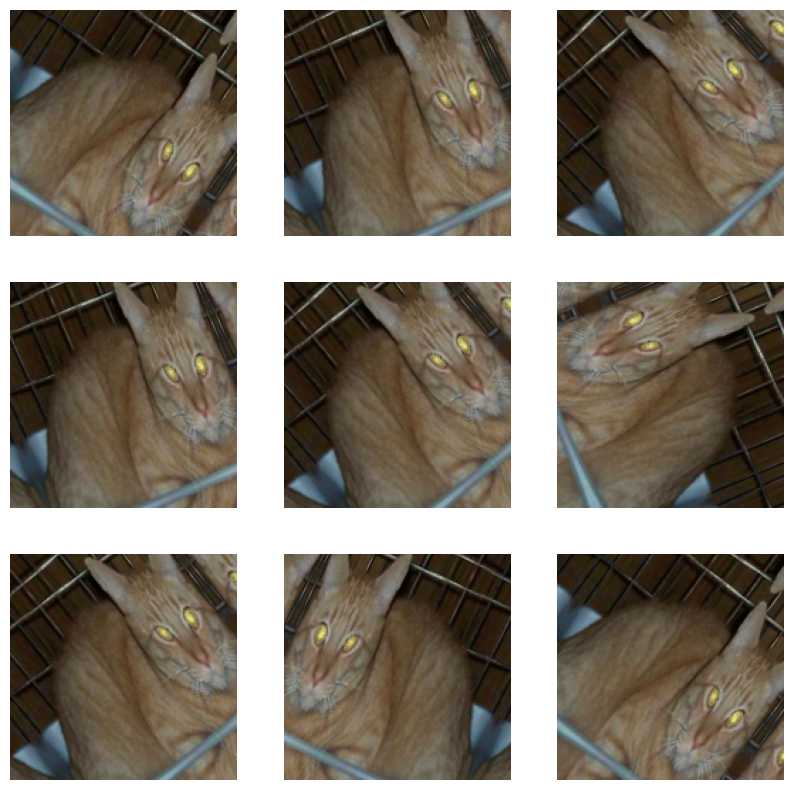

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
#Kode berikut digunakan untuk menginisialisasi model dasar dari arsitektur MobileNetV2 dengan menggunakan TensorFlow dan Keras.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
# Arsiteltur model dasar
model.summary() 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
len(model.trainable_variables)

2

### Proses Learning Algoritma Optimizer Adam

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [20]:
%%time
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 728ms/step - accuracy: 0.5189 - loss: 0.7589
CPU times: total: 27.1 s
Wall time: 25.2 s


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.74
initial accuracy: 0.53


In [22]:
%%time
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, verbose=0)

CPU times: total: 16min 40s
Wall time: 9min 34s


### Evaluasi learning dan testing untuk grafik performance dan loss function Algoritma Optimizer Adam

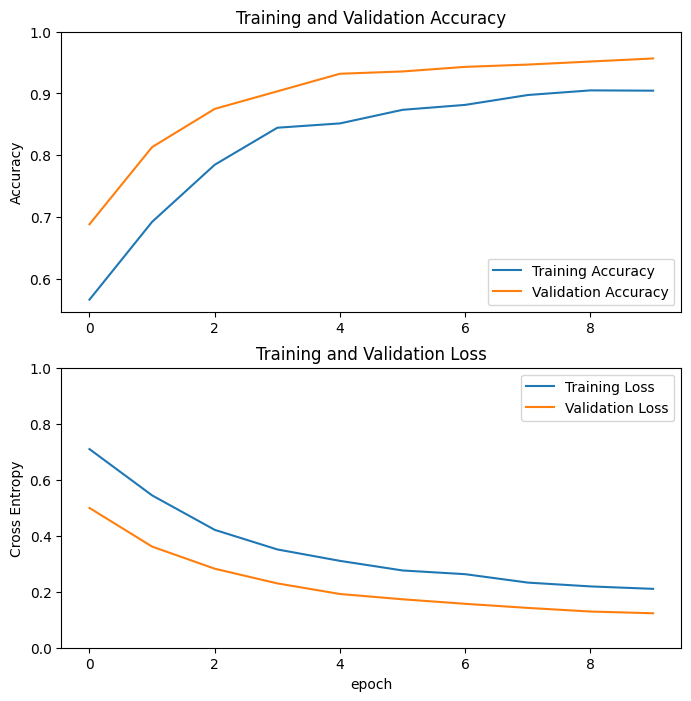

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
# print final training and validation accuracy
loss, accuracy = model.evaluate(train_dataset)
print("Training accuracy: {:.2f}".format(accuracy))

loss, accuracy = model.evaluate(validation_dataset)
print("Validation accuracy: {:.2f}".format(accuracy))

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 577ms/step - accuracy: 0.9550 - loss: 0.1175
Training accuracy: 0.95
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.9500 - loss: 0.1252
Validation accuracy: 0.96


In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Proses Learning Algoritma Optimizers RMSprop

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [28]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [29]:
len(model.trainable_variables)

56

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset, verbose=1)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8413 - loss: 0.4134 - val_accuracy: 0.9752 - val_loss: 0.0778
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9090 - loss: 0.2478 - val_accuracy: 0.9740 - val_loss: 0.0644
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9134 - loss: 0.2096 - val_accuracy: 0.9814 - val_loss: 0.0529
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9303 - loss: 0.1835 - val_accuracy: 0.9839 - val_loss: 0.0527
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 989ms/step - accuracy: 0.9295 - loss: 0.1690 - val_accuracy: 0.9901 - val_loss: 0.0420
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 989ms/step - accuracy: 0.9361 - loss: 0.1443 - val_accuracy: 0.9851 - val_loss: 0.0450
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 934ms/step - accuracy: 0.9382 - loss: 0.1505 - val_accuracy: 0.9864 - val_loss: 0.0380
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9399 - loss: 0.1328 - val_accuracy: 

### Evaluasi learning dan testing untuk grafik performance dan loss function Algoritma Optimizer RMSprop

In [36]:
# Initialize the variables as lists
acc = []
val_acc = []
loss = []
val_loss = []

# Add the history data
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

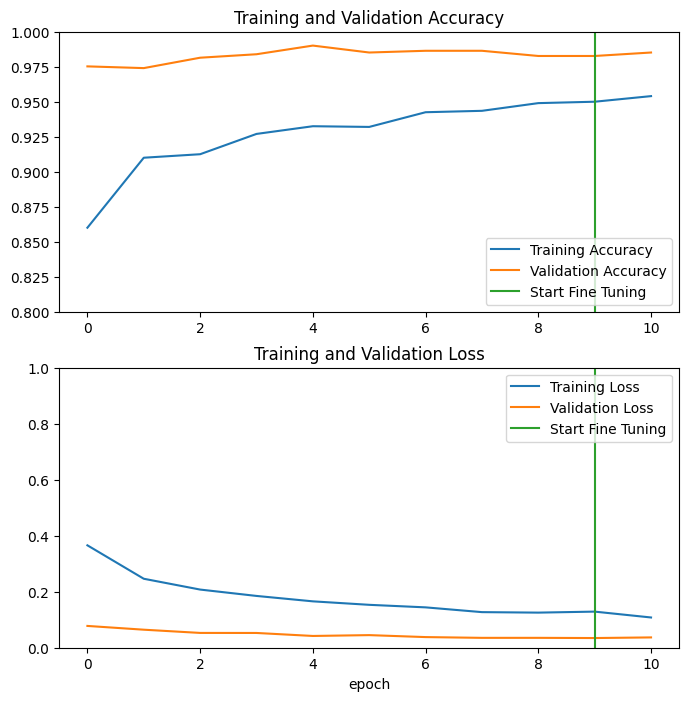

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
# print the training and validation accuracies of the fine-tuned model
loss, accuracy = model.evaluate(train_dataset)
print("Training accuracy: {:.2f}".format(accuracy))

loss, accuracy = model.evaluate(validation_dataset)
print("Validation accuracy: {:.2f}".format(accuracy))

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.9963 - loss: 0.0205
Training accuracy: 0.99
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step - accuracy: 0.9773 - loss: 0.0482
Validation accuracy: 0.98


### Proses testing

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.9626 - loss: 0.0501
Test accuracy : 0.9791666865348816


### Cek beberapa sampel untuk prediksi

Predictions:
 [1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0]
Labels:
 [1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1]


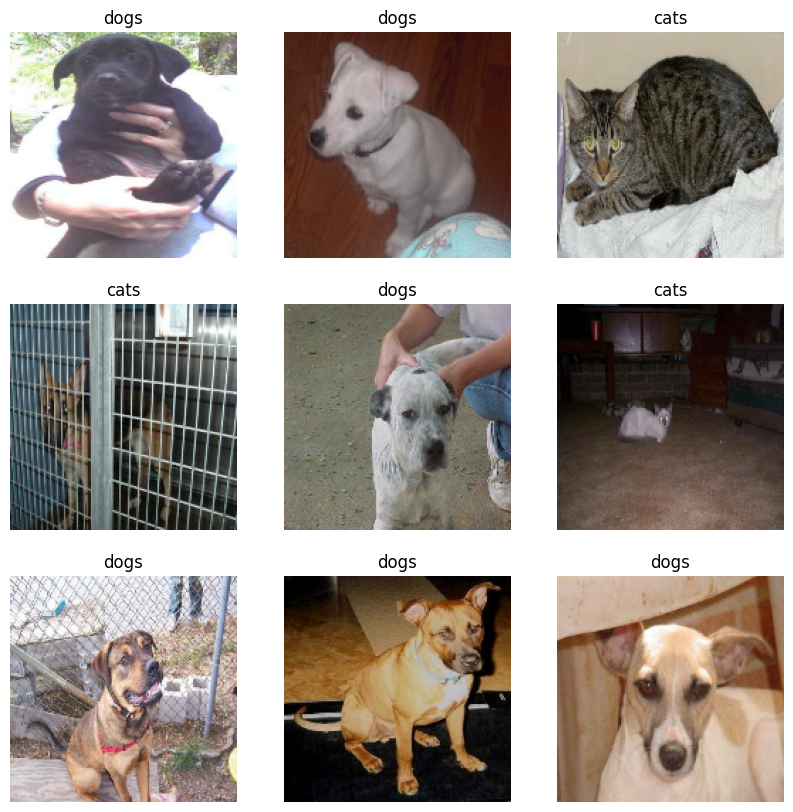

In [35]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Analisis Model Convolutional Neural Network (CNN)

### 1. Preprocessing dan Data Augmentation
- **Preprocessing**: Gambar-gambar dari dataset dimuat, diresize ke ukuran yang ditentukan (160x160), dan dibagi menjadi batch-batch untuk pelatihan (`train_dataset`) dan validasi (`validation_dataset`).
- **Data Augmentation**: Dilakukan untuk meningkatkan variasi data pelatihan dengan menerapkan augmentasi seperti flip horizontal dan rotasi pada gambar-gambar pelatihan.

### 2. Base Model: MobileNetV2
- Model dasar yang digunakan adalah MobileNetV2 yang telah dilatih sebelumnya pada dataset ImageNet. Ini adalah model yang telah terbukti baik dalam tugas-tugas visi komputer.
- **Feature Extraction**: Bagian atas (top layer) dari MobileNetV2 dihapus (`include_top=False`) sehingga hanya bagian convolutional base yang digunakan untuk ekstraksi fitur.
- **Global Average Pooling**: Dilakukan setelah ekstraksi fitur untuk menghasilkan representasi rata-rata global dari setiap fitur spatialis.

### 3. Model Top Layers
- **Penambahan Layer**: Setelah ekstraksi fitur, ditambahkan beberapa lapisan di atas MobileNetV2 untuk tugas klasifikasi biner.
- **Dropout**: Digunakan untuk mengurangi overfitting dengan menonaktifkan sebagian unit selama pelatihan.
- **Dense Layer**: Layer terakhir menggunakan dense layer dengan 1 unit karena ini adalah masalah klasifikasi biner.

### 4. Pelatihan dan Evaluasi Model
- **Compiling Model**: Model dikompilasi dengan optimizer Adam, binary crossentropy loss function, dan binary accuracy sebagai metrik.
- **Pelatihan**: Dilakukan dalam dua tahap, yaitu pelatihan awal dan fine-tuning:
  - **Pelatihan Awal**: Dilakukan untuk beberapa epoch pertama pada layer top yang ditambahkan.
  - **Fine-Tuning**: Beberapa layer atas dari MobileNetV2 dilepas dari pembekuan (freeze) untuk dilatih ulang dengan learning rate yang lebih rendah.
- **Evaluasi**: Hasil pelatihan dievaluasi menggunakan grafik training/validation accuracy dan loss. Model dievaluasi pada data pelatihan, validasi, dan data uji (`test_dataset`).

### 5. Testing dan Prediksi
- **Prediksi**: Model digunakan untuk memprediksi kelas dari beberapa sampel data uji (`test_dataset`). Hasilnya dievaluasi menggunakan metrik akurasi.
- **Visualisasi**: Beberapa sampel dari data uji ditampilkan bersama dengan prediksi yang dibuat oleh model.

### Kesimpulan
Model CNN yang digunakan dalam kode ini adalah MobileNetV2 yang telah dimodifikasi untuk tugas klasifikasi biner pada dataset kucing dan anjing. Proses pelatihan melibatkan augmentasi data, penggunaan pretrained model untuk ekstraksi fitur, dan fine-tuning untuk meningkatkan kinerja pada dataset spesifik. Hasil akhirnya dievaluasi dengan metrik akurasi dan visualisasi prediksi. Ini adalah pendekatan yang umum digunakan dalam transfer learning untuk masalah klasifikasi gambar.
